In [1]:
!cat job22/main.sh

#!/bin/bash
set -euxo pipefail

cat ${BASH_SOURCE[0]}

WORKDIR=$(pwd)

STRIDE=0

if [ -v SLURM_ARRAY_TASK_ID ]; then
  SEED="$((SLURM_ARRAY_TASK_ID+STRIDE))"
  WORKDIR="${WORKDIR}/${SLURM_ARRAY_JOB_ID}_${SEED}"
else
  SEED="0"
fi

ROOTDIR="/home/kaizu/t1/ctrw"
cd ${ROOTDIR}

mkdir --parents ${WORKDIR}

TRACER_DIAMETER=`python -c "print([10, 15, 18][(${SEED}%3)])"`
CROWDER_CONSTRAINT_DIAMETER=`python -c "print([0, 16, 28][(${SEED}//3%3)])"`
D_CROWDER=`python -c "print([9.375, 0.3, 0.05][(${SEED}//9%3)])"`
CROWDER_DIAMETER="9.6"
N_CROWDER_RIGHT="692"
DT="1e-9"

# IDX=`python -c "print(${SEED}//(11*17*2))"`
IDX=`python -c "print(${SEED}//27)"`

date

${ROOTDIR}/build/a.out $SEED $TRACER_DIAMETER $CROWDER_CONSTRAINT_DIAMETER $D_CROWDER $CROWDER_DIAMETER $N_CROWDER_RIGHT $DT | tee ${WORKDIR}/result_${TRACER_DIAMETER}_${CROWDER_CONSTRAINT_DIAMETER}_${D_CROWDER}_${CROWDER_DIAMETER}_${N_CROWDER_RIGHT}_${DT}_${IDX}.csv

date


In [2]:
!ls job22

84189_0     84729_3186	       slurm-84189_100.out   slurm-84729_318.out
84189_1     84729_3187	       slurm-84189_101.out   slurm-84729_3190.out
84189_10    84729_3188	       slurm-84189_102.out   slurm-84729_3191.out
84189_100   84729_3189	       slurm-84189_103.out   slurm-84729_3192.out
84189_101   84729_319	       slurm-84189_104.out   slurm-84729_3193.out
84189_102   84729_3190	       slurm-84189_105.out   slurm-84729_3194.out
84189_103   84729_3191	       slurm-84189_106.out   slurm-84729_3195.out
84189_104   84729_3192	       slurm-84189_107.out   slurm-84729_3196.out
84189_105   84729_3193	       slurm-84189_108.out   slurm-84729_3197.out
84189_106   84729_3194	       slurm-84189_109.out   slurm-84729_3198.out
84189_107   84729_3195	       slurm-84189_10.out    slurm-84729_3199.out
84189_108   84729_3196	       slurm-84189_110.out   slurm-84729_319.out
84189_109   84729_3197	       slurm-84189_111.out   slurm-84729_31.out
84189_11    84729_3198	       slurm-84189_112.out   slur

In [3]:
import glob, sys, os.path, itertools, pathlib
from collections import defaultdict
import numpy

In [4]:
artifacts = pathlib.Path("./artifacts")

In [5]:
sys.path.append("/home/kaizu/t1/ctrw")
import scripts.io

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
plt.rcParams["figure.dpi"] = 120

In [7]:
interval = 0.004
L1 = 0.149

In [8]:
N_tracer = 10
deltax = 0.050

In [9]:
fmt = "job22/84729_*/result_*_*_*_*_*_*_*.csv"
filenames1 = glob.glob(fmt)
print(len(filenames1))
filenames1 = scripts.io.clasify_files(filenames1)

5400


In [10]:
def read_file3d(filename, L=None, data=None, sp=None):
    data = data or defaultdict(list)
    
    tmp = defaultdict(lambda : defaultdict(list))
    with filename.open("r") as f:
        for line in f:
            if line.startswith('#'):
                continue
            row = line.strip().split(",")
            assert len(row) == 6
            t_, sp_, idx_, x_, y_, z_ = row
            t, idx, x, y, z = float(t_), int(idx_), float(x_), float(y_), float(z_)

            # assert sp_ == "X"
            if sp is not None and sp_ != sp:
                continue

            if L is not None:
                x, y, z = x % L, y % L, z % L

            tmp[sp_][idx].append(numpy.array([t, x, y, z]))
    
    for sp, positions in tmp.items():
        data[sp].extend(numpy.array(value) for _, value in positions.items())
    return data

def read_files3d(filenames, L=None, sp=None):
    data = {}
    for filename in filenames:
        if isinstance(filename, str):
            filename = pathlib.Path(filename)
        data = read_file3d(filename, L, data, sp)
    return data

In [11]:
data1 = {}
for key, filenames in filenames1.items():
    data_ = read_files3d(filenames)
    data1[key] = data_

In [12]:
displacements = {}
for key, data in data1.items():
    displacements[key] = {}
    for sp, positions in data.items():
        # print(f"{key}, {sp}, {len(positions)}")
        t = positions[0].T[0]  # t
        # msd = sum((x - x[0]).T[2] ** 2 for x in positions) / len(positions)  # Y        
        msd = sum(sum((x - x[0]).T[1: ] ** 2) for x in positions) / len(positions)  # R
        displacements[key][sp] = (t, msd)

In [13]:
def replace_at_index(tup, idx, val):
    lst = list(tup)
    lst[idx] = val
    return tuple(lst)

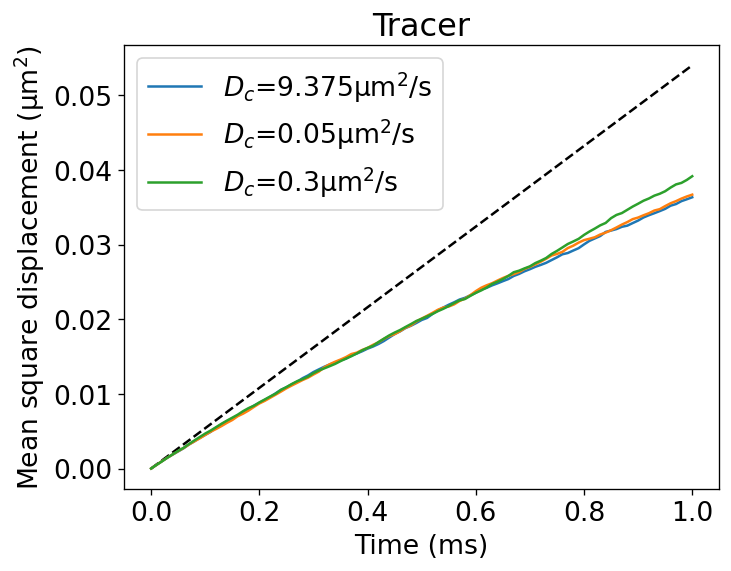

In [14]:
key1 = ('10', '0', '9.375', '9.6', '692', '1e-9')

fig, ax1 = plt.subplots()

D = 90 / float(key1[0])
ax1.plot(displacements[key1]["X"][0] * 1000, 6 * D * displacements[key1]["X"][0], 'k--')

for D_crowder_ in ('9.375', '0.05', '0.3'):
    newkey = replace_at_index(key1, 2, D_crowder_)
    ax1.plot(displacements[newkey]["X"][0] * 1000, displacements[newkey]["X"][1], '-', label=rf"$D_c$={D_crowder_}$\mathrm{{\mu m^2/s}}$")

ax1.set_xlabel("Time (ms)")
ax1.set_ylabel(r"Mean square displacement ($\mathrm{\mu m^2}$)")
plt.legend(loc='best')
plt.title("Tracer")
fig.savefig(artifacts / 'Mobile_Immobile2-01.svg', format='svg')
plt.show()

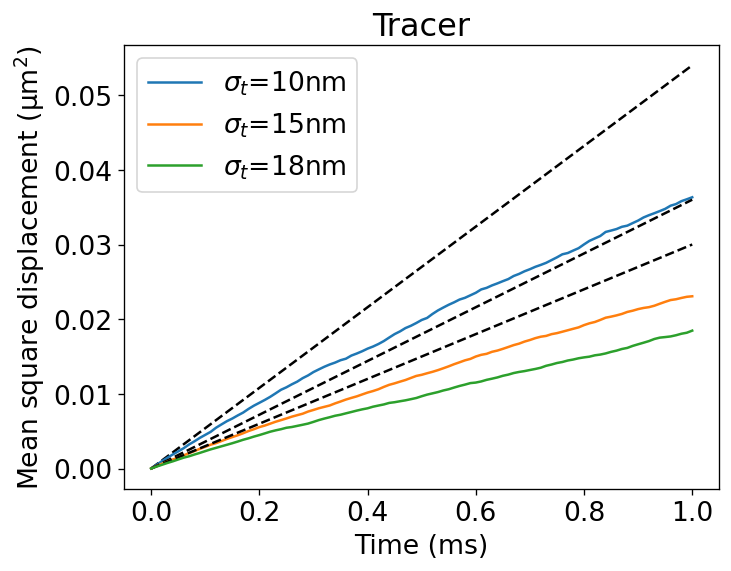

In [15]:
key1 = ('10', '0', '9.375', '9.6', '692', '1e-9')

fig, ax1 = plt.subplots()

for tracer_diameter_ in ('10', '15', '18'):
    newkey = replace_at_index(key1, 0, tracer_diameter_)
    ax1.plot(displacements[newkey]["X"][0] * 1000, 6 * (90 / float(tracer_diameter_)) * displacements[newkey]["X"][0], 'k--')
    ax1.plot(displacements[newkey]["X"][0] * 1000, displacements[newkey]["X"][1], '-', label=rf"$\sigma_t$={tracer_diameter_}nm")

ax1.set_xlabel("Time (ms)")
ax1.set_ylabel(r"Mean square displacement ($\mathrm{\mu m^2}$)")
plt.legend(loc='best')
plt.title("Tracer")
fig.savefig(artifacts / 'Mobile_Immobile2-02.svg', format='svg')
plt.show()

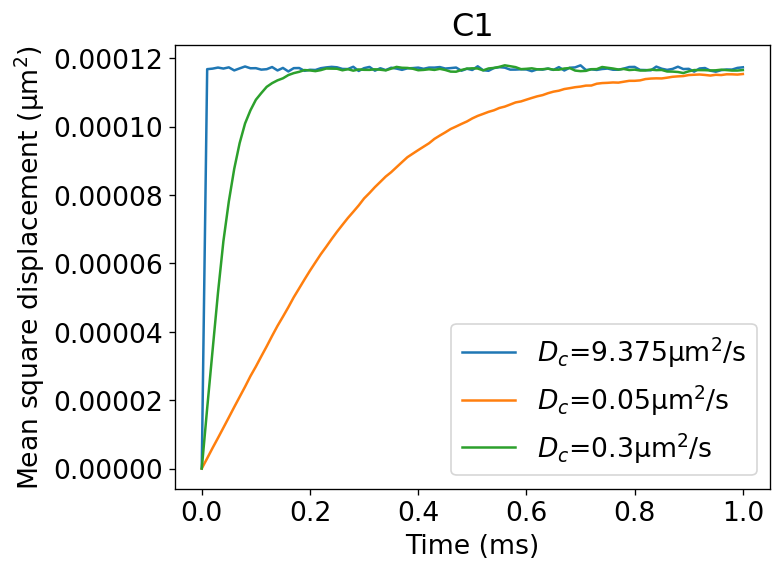

In [16]:
key1 = ('10', '28', '9.375', '9.6', '692', '1e-9')

fig, ax1 = plt.subplots()

D = 90 / float(key1[0])
# ax1.plot(displacements[key1]["X"][0] * 1000, 2 * D * displacements[key1]["X"][0], 'k--')

for D_crowder_ in ('9.375', '0.05', '0.3'):
    newkey = replace_at_index(key1, 2, D_crowder_)
    ax1.plot(displacements[newkey]["C1"][0] * 1000, displacements[newkey]["C1"][1], '-', label=rf"$D_c$={D_crowder_}$\mathrm{{\mu m^2/s}}$")

ax1.set_xlabel("Time (ms)")
ax1.set_ylabel(r"Mean square displacement ($\mathrm{\mu m^2}$)")
plt.legend(loc='best')
plt.title("C1")
fig.savefig(artifacts / 'Mobile_Immobile2-03.svg', format='svg')
plt.show()

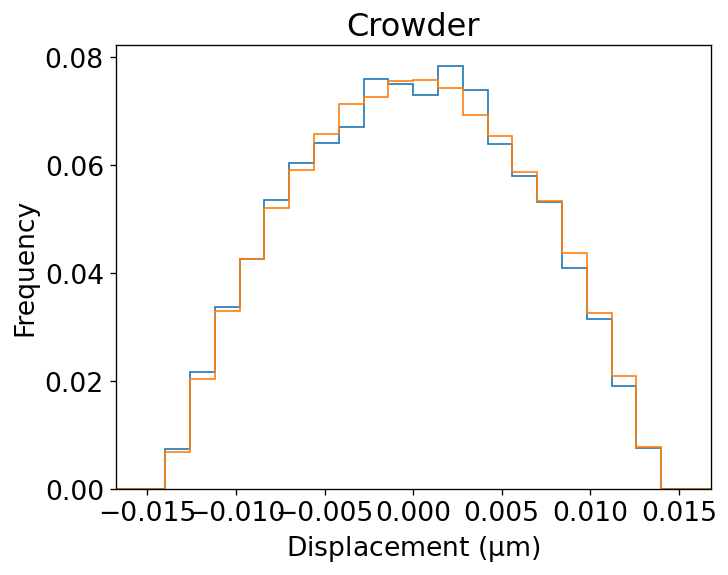

In [17]:
key1 = ('10', '28', '9.375', '9.6', '692', '1e-9')

fig, ax1 = plt.subplots()

constraint_radius = 0.014
bins = numpy.linspace(-constraint_radius * 1.2, +constraint_radius * 1.2, 25)

x = numpy.array([(x - x[0])[-1] for x in data1[key1]["C1"]]).T[2]
counts, _ = numpy.histogram(x, bins=bins)
plt.stairs(counts / sum(counts), bins)

x = numpy.array([(x - x[0])[-1] for x in data1[key1]["C2"]]).T[2]
counts, _ = numpy.histogram(x, bins=bins)
plt.stairs(counts / sum(counts), bins)

plt.xlim(bins.min(), bins.max())
plt.ylabel("Frequency")
plt.xlabel(r"Displacement ($\mathrm{\mu m}$)")
plt.title("Crowder")
fig.savefig(artifacts / 'Mobile_Immobile2-04.svg', format='svg')
plt.show()

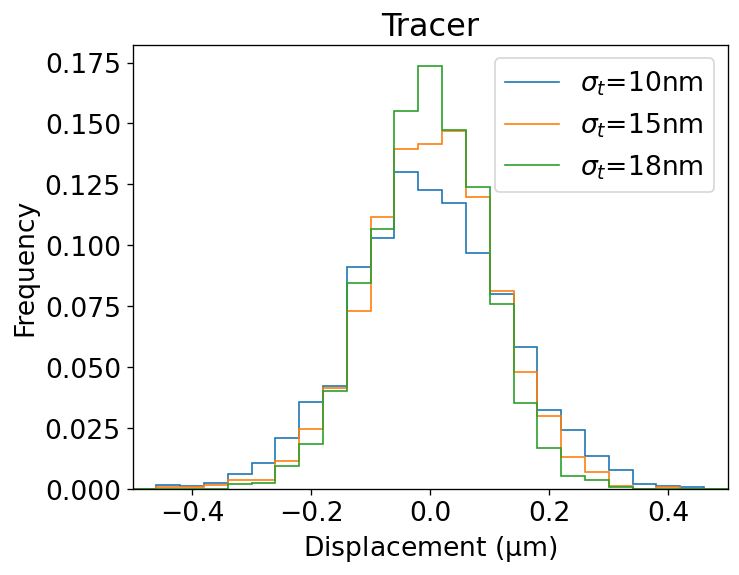

In [18]:
key1 = ('10', '28', '9.375', '9.6', '692', '1e-9')

bins = numpy.linspace(-0.5, +0.5, 26)

fig, ax1 = plt.subplots()

for tracer_diameter_ in ('10', '15', '18'):
    x = numpy.array([(x - x[0])[-1] for x in data1[replace_at_index(key1, 0, tracer_diameter_)]["X"]]).T[2]
    counts, _ = numpy.histogram(x, bins=bins)
    plt.stairs(counts / sum(counts), bins, label=fr"$\sigma_t$={tracer_diameter_}nm")

plt.xlim(bins.min(), bins.max())
plt.ylabel("Frequency")
plt.xlabel(r"Displacement ($\mathrm{\mu m}$)")
plt.title("Tracer")
plt.legend(loc='best')
fig.savefig(artifacts / 'Mobile_Immobile2-05.svg', format='svg')
plt.show()

In [60]:
list(reversed(sorted([(i, x.T[1].max()) for i, x in enumerate(data1[key1]["X"])], key=lambda x: x[1])))[: 10]

[(1345, 0.297906),
 (185, 0.29786),
 (1519, 0.284802),
 (591, 0.283654),
 (1354, 0.27782),
 (402, 0.272288),
 (496, 0.272224),
 (299, 0.255035),
 (820, 0.255017),
 (1591, 0.253758)]

[0.0157426  0.0349957  0.0449944  0.044575   0.0429061  0.028394
 0.023267   0.0118055  0.00751596 0.00315351 0.00779124 0.0268783
 0.0234852  0.00732005 0.0194459  0.0459583  0.0261964  0.0163595
 0.0148511  0.0292747  0.0376264  0.0411664  0.0372624  0.0296959
 0.0365191  0.0186812  0.0179653  0.0126159  0.0297675  0.035178
 0.0474529  0.075133   0.0957977  0.0870904  0.0720395  0.0679327
 0.069617   0.0795303  0.0730268  0.0572999  0.0441788  0.0409246
 0.0325384  0.0355322  0.0285839  0.0410833  0.0463262  0.0610876
 0.0668269  0.0880521  0.115519   0.118782   0.122952   0.116299
 0.135268   0.119766   0.121716   0.133928   0.142164   0.141334
 0.142373   0.132377   0.147173   0.135191   0.164512   0.172611
 0.180434   0.189132   0.187973   0.195069   0.205254   0.224099
 0.221428   0.235295   0.230931   0.234217   0.241042   0.251107
 0.249263   0.252433   0.252166   0.242348   0.247329   0.262767
 0.265575   0.267191   0.24977    0.242466   0.254595   0.262754
 0.266196   0.27222

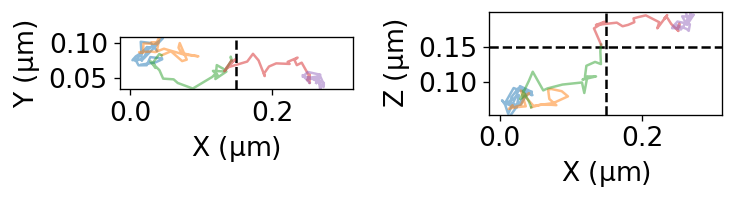

In [65]:
idx = 496
key1 = ('15', '28', '0.3', '9.6', '692', '1e-9')
positions = data1[key1]["X"][idx][:, 1: ].T
print(positions[0], len(positions[0]))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot((-0.1 * L1, 2.1 * L1), (0, 0), 'k--')
ax1.plot((-0.1 * L1, 2.1 * L1), (L1, L1), 'k--')
ax1.plot((L1, L1), (positions[1].min(), positions[1].max()), 'k--')

for i in range(5):
    n = len(positions[0]) // 5
    ax1.plot(positions[0][n * i: n * (i + 1) + 1], positions[1][n * i: n * (i + 1) + 1], '-', label=sp, alpha=0.5)

ax1.set_xlim(-0.1 * L1, 2.1 * L1)
ax1.set_ylim(positions[1].min(), positions[1].max())
ax1.set_aspect('equal')
# plt.legend(loc='best')
ax1.set_xlabel(r'X ($\mathrm{\mu m}$)')
ax1.set_ylabel(r'Y ($\mathrm{\mu m}$)')

ax2.plot((-0.1 * L1, 2.1 * L1), (0, 0), 'k--')
ax2.plot((-0.1 * L1, 2.1 * L1), (L1, L1), 'k--')
ax2.plot((L1, L1), (positions[2].min(), positions[2].max()), 'k--')

for i in range(5):
    n = len(positions[0]) // 5
    ax2.plot(positions[0][n * i: n * (i + 1) + 1], positions[2][n * i: n * (i + 1) + 1], '-', label=sp, alpha=0.5)

ax2.set_xlim(-0.1 * L1, 2.1 * L1)
ax2.set_ylim(positions[2].min(), positions[2].max())
ax2.set_aspect('equal')
# plt.legend(loc='best')
ax2.set_xlabel(r'X ($\mathrm{\mu m}$)')
ax2.set_ylabel(r'Z ($\mathrm{\mu m}$)')

fig.tight_layout()
# fig.savefig(artifacts / 'Mobile_Immobile1-02.svg', format='svg')
plt.show()

In [69]:
filenames1[('15', '0', '0.3', '9.6', '692', '1e-9')][0]

PosixPath('job22/84729_4222/result_15_0_0.3_9.6_692_1e-9_156.csv')

In [70]:
fmt = "job22/90249_*/result_*_*_*_*_*_*_*.csv"
filenames2 = glob.glob(fmt)
print(len(filenames2))
filenames2 = scripts.io.clasify_files(filenames2)

120


In [71]:
data2 = {}
for key, filenames in filenames2.items():
    data_ = read_files3d(filenames)
    data2[key] = data_

In [129]:
def diameter2radius(diameter_: str) -> str:
    diameter = float(diameter_)
    radius = diameter / 2
    if radius.is_integer():
        return f"{int(radius):d}"
    else:
        return f"{radius:g}"

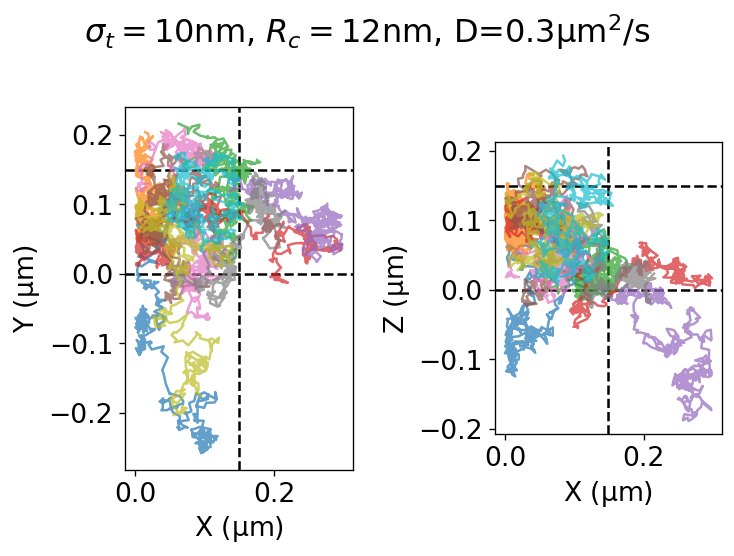

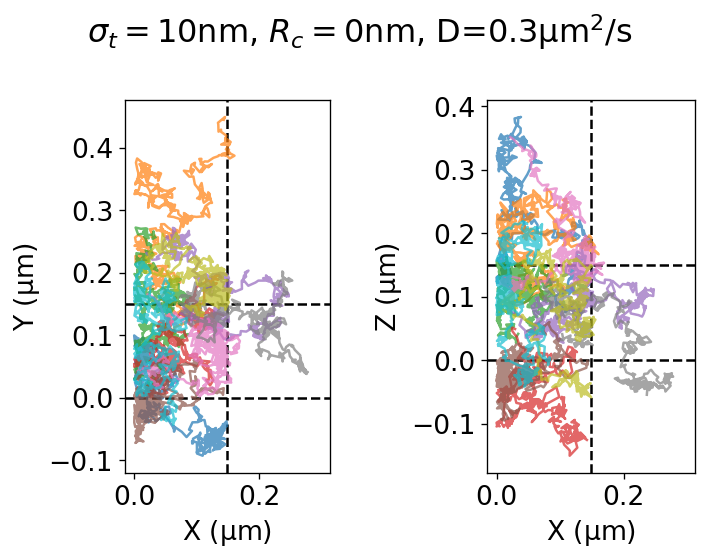

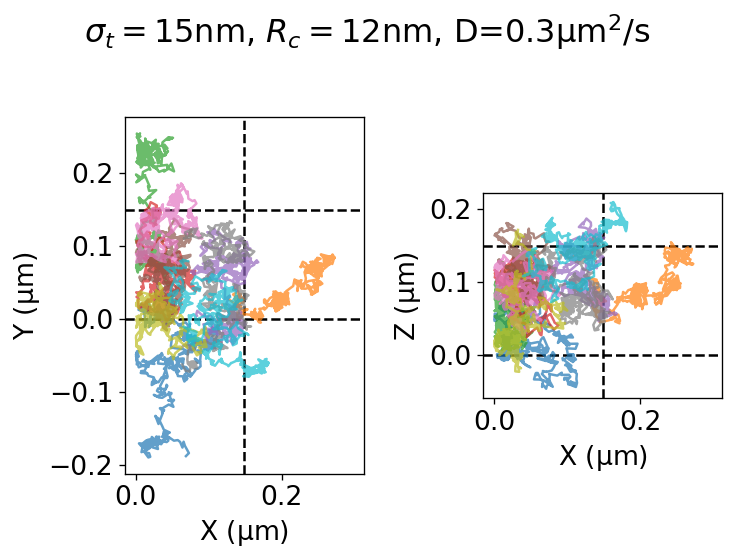

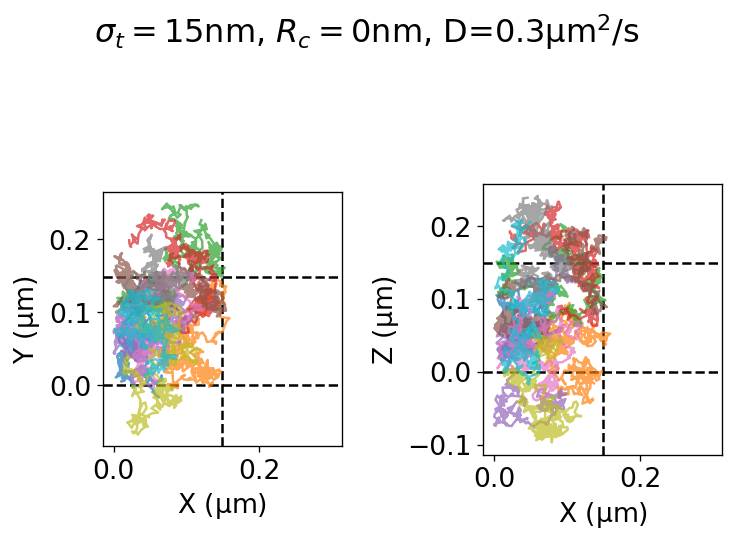

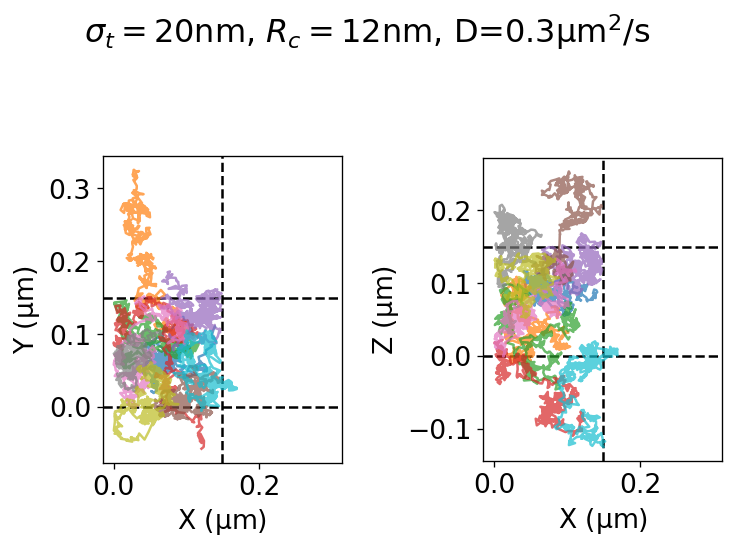

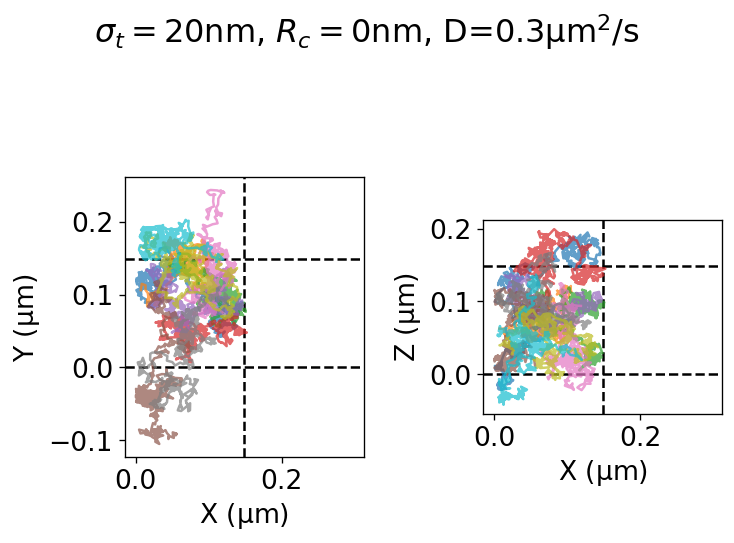

In [140]:
key_list = [
    (('10', '24', '0.3', '9.6', '692', '1e-9'), 3),
    (('10', '0', '0.3', '9.6', '692', '1e-9'), 3),
    (('15', '24', '0.3', '9.6', '692', '1e-9'), 10),
    (('15', '0', '0.3', '9.6', '692', '1e-9'), 3),
    (('20', '24', '0.3', '9.6', '692', '1e-9'), 1),
    (('20', '0', '0.3', '9.6', '692', '1e-9'), 0),
    ]

for fig_num, (key1, start) in enumerate(key_list):
    all_positions = [data2[key1]["X"][i][:, 1: ].T for i in range(len(data2[key1]["X"]))]
    all_positions = all_positions[start * 10: (start + 1) * 10]

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    fig, (ax1, ax2) = plt.subplots(1, 2)

    vmin = min(all_positions[i][1].min() for i in range(len(all_positions)))
    vmax = max(all_positions[i][1].max() for i in range(len(all_positions)))
    vmin, vmax = vmin - (vmax - vmin) * 0.05, vmax + (vmax - vmin) * 0.05
    ax1.plot((-0.1 * L1, 2.1 * L1), (0, 0), 'k--')
    ax1.plot((-0.1 * L1, 2.1 * L1), (L1, L1), 'k--')
    ax1.plot((L1, L1), (vmin, vmax), 'k--')
    for idx in range(len(all_positions)):
        positions = all_positions[idx]
        ax1.plot(positions[0], positions[1], '-', label=sp, alpha=0.7, color=colors[idx])
    ax1.set_xlim(-0.1 * L1, 2.1 * L1)
    ax1.set_ylim(vmin, vmax)
    ax1.set_aspect('equal')
    ax1.set_xlabel(r'X ($\mathrm{\mu m}$)')
    ax1.set_ylabel(r'Y ($\mathrm{\mu m}$)')

    vmin = min(all_positions[i][2].min() for i in range(len(all_positions)))
    vmax = max(all_positions[i][2].max() for i in range(len(all_positions)))
    vmin, vmax = vmin - (vmax - vmin) * 0.05, vmax + (vmax - vmin) * 0.05
    ax2.plot((-0.1 * L1, 2.1 * L1), (0, 0), 'k--')
    ax2.plot((-0.1 * L1, 2.1 * L1), (L1, L1), 'k--')
    ax2.plot((L1, L1), (vmin, vmax), 'k--')
    for idx in range(len(all_positions)):
        positions = all_positions[idx]
        ax2.plot(positions[0], positions[2], '-', label=sp, alpha=0.7, color=colors[idx])
    ax2.set_xlim(-0.1 * L1, 2.1 * L1)
    ax2.set_ylim(vmin, vmax)
    ax2.set_aspect('equal')
    ax2.set_xlabel(r'X ($\mathrm{\mu m}$)')
    ax2.set_ylabel(r'Z ($\mathrm{\mu m}$)')

    fig.suptitle(fr"$\sigma_t=${key1[0]}nm, $R_c=${diameter2radius(key1[1])}nm, D={key1[2]}$\mathrm{{\mu m^2/s}}$")
    fig.tight_layout()
    fig.savefig(artifacts / f'Mobile_Immobile2-06-{fig_num:d}.svg', format='svg')
    plt.show()